# Intel Image Classification Using Transfer Learning
This notebook focuses on performing image classification on the Intel Image Classification dataset using transfer learning. Transfer learning is a technique that leverages pre-trained models to solve similar tasks in different domains. In this case, we will use a pre-trained deep learning model **`MobileNetV2`**as a starting point and fine-tune it for our specific image classification task.
## Problem Definition: Intel Image Classification

The problem at hand is to develop a deep learning model that can accurately classify images from the Intel Image Classification dataset. The dataset consists of a large collection of images belonging to various natural scenes, including buildings, forests, mountains, glaciers, and street views.

### Goal
The goal is to create a robust image classification model that can identify and categorize the scenes depicted in the images accurately. This task involves training a deep learning model on a labeled dataset, where each image is associated with a specific class or category.

### Problem Statement
Given a set of images representing different natural scenes, along with their corresponding labels indicating the scene category, the objective is to develop a high-performing deep learning model that can accurately classify unseen images into their respective scene categories.

### Evaluation
The performance of the model can be evaluated using various metrics such as accuracy, precision, recall, and F1 score. The model should aim to achieve high accuracy and minimize misclassifications.

### Approach
To solve this problem, we will perform tasks such as data preprocessing, model selection, model training, and model evaluation. By training a deep learning model on the labeled dataset, we aim to create a reliable image classification model that can generalize well to unseen images and accurately classify them based on their scene category.



In [1]:
# Importing important libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2 as cv
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense , Flatten , Dropout ,MaxPool2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip , RandomRotation

## Loading Data
I have downloaded data from kaggle:-https://www.kaggle.com/datasets/puneet6060/intel-image-classification

This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

In [74]:
IMAGE_SIZE =(224,224)
BATCH_SIZE = 32
train_path = "drive/MyDrive/intel image/seg_train/seg_train"
val_path = "drive/MyDrive/intel image/seg_test/seg_test"
test_path = "drive/MyDrive/intel image/seg_pred"

train_dataset = image_dataset_from_directory(train_path,
                                             label_mode ="categorical",
                                             batch_size=BATCH_SIZE,
                                             image_size = IMAGE_SIZE,
                                             seed=42)
val_dataset = image_dataset_from_directory(val_path ,
                                           label_mode="categorical",
                                           image_size = IMAGE_SIZE,
                                           batch_size =BATCH_SIZE,
                                           seed = 42)
test_dataset = image_dataset_from_directory(test_path,
                                            image_size=IMAGE_SIZE,
                                            batch_size = BATCH_SIZE)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


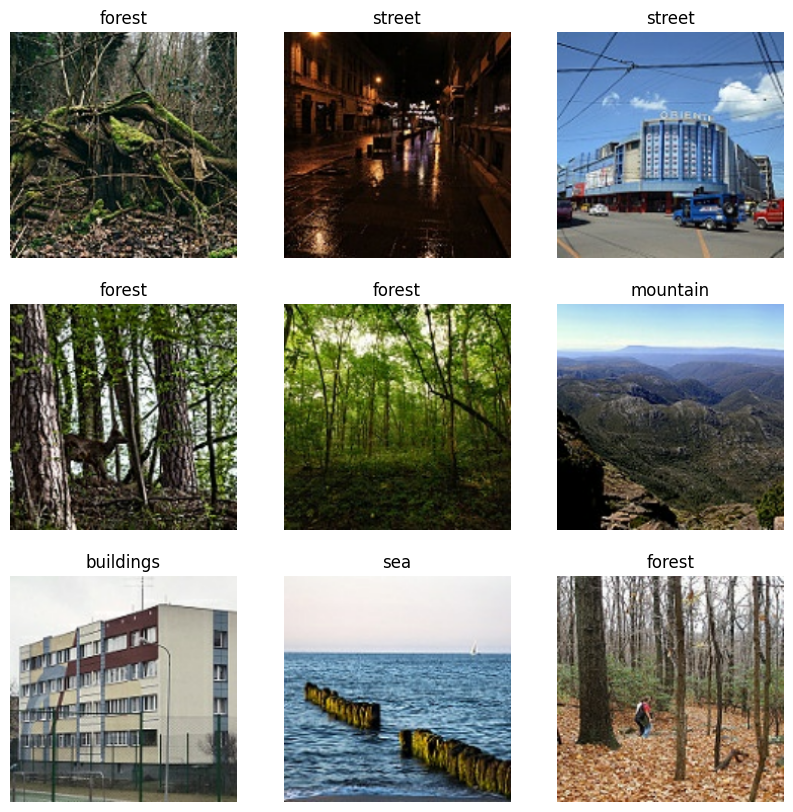

In [75]:
#images from training dataset
class_names = train_dataset.class_names
plt.figure(figsize=(10,10))
for image , label in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(label[i])])
    plt.axis("off")

In [76]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

Autotuning on the training dataset is used to automatically search for the optimal hyperparameters or configuration for a machine learning model. The primary goal of autotuning is to improve the model's performance and generalization ability by finding the best combination of hyperparameters.

In [77]:
# data agumentation
def data_agumenter():
  data_agumentation = tf.keras.Sequential()
  data_agumentation.add(RandomFlip("horizontal"))
  data_agumentation.add(RandomRotation(0.2))
  return data_agumentation


Data augmentation is a technique used in computer vision to artificially increase the size and diversity of a training dataset by applying various transformations or modifications to the existing data. It is commonly employed to improve the generalization and robustness of deep learning models.

The idea behind data augmentation is to generate additional training samples that are realistic and representative of the underlying data distribution. By applying random transformations to the existing data, the model becomes exposed to different variations of the same data instances, which helps it learn more invariant and discriminative features.

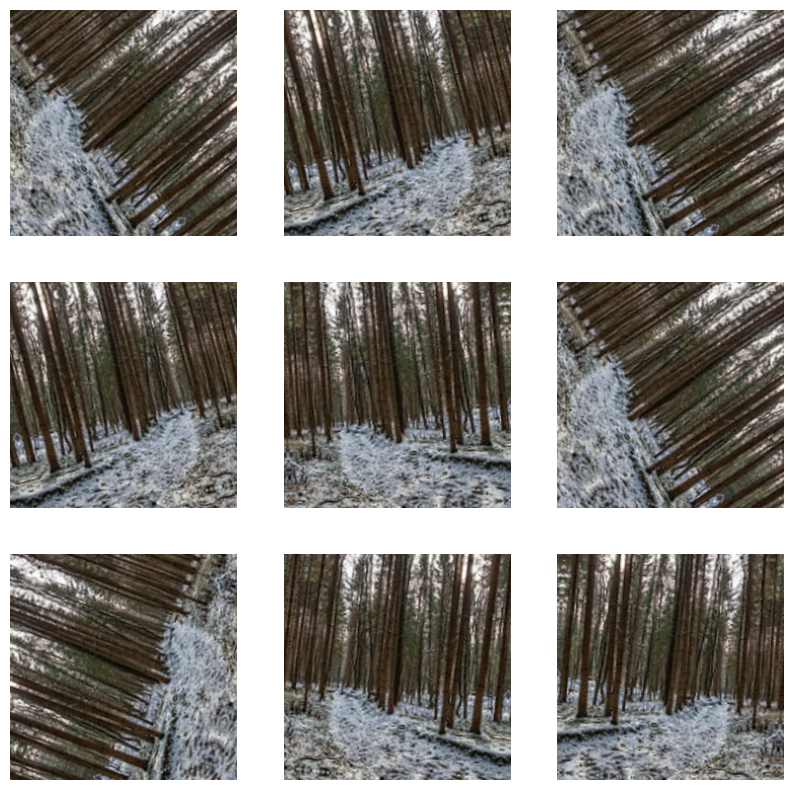

In [78]:
data_agumentation = data_agumenter()
for image , _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    augmented_image = data_agumentation(tf.expand_dims(first_image , 0))
    plt.imshow(augmented_image[0]/255)
    plt.axis("off")

In [79]:
path ="drive/MyDrive/intel image/mobile_net.h5"
checkpoint =ModelCheckpoint(path , monitor = "val_loss" ,verbose =True ,save_best_only=True , save_weights_only=False )

The ModelCheckpoint callback is commonly used to save the best or latest model weights during the training process. When using save_best_only=True, it will save only the best model based on a specified metric, such as validation accuracy or loss.

### MobileNetV2
MobileNetV2 is a lightweight and efficient convolutional neural network architecture specifically designed for mobile and embedded devices with limited computational resources. It is an extension of the original MobileNetV1 model, aiming to improve both accuracy and efficiency.

MobileNetV2 has demonstrated excellent performance on a wide range of mobile and embedded vision applications, striking a balance between model size, computational efficiency, and accuracy. It has become a popular choice for deploying deep learning models on resource-constrained devices.

I am using MobileNetV2  because its efficient and lightweight design allows for optimal performance on resource-constrained devices, making it an ideal choice for my specific application requirements. Additionally, MobileNetV2's ability to maintain good accuracy across various computer vision tasks ensures reliable and effective results.


## Loading Pretrained Model

In [80]:
# create the base pretrained model
input_size = IMAGE_SIZE + (3,)
base_model = MobileNetV2(input_shape=input_size,
                   include_top=False,
                   weights = "imagenet")

Modifing the MobileNetV2 model for our own dataset I going to  load only convolution blocks not fully connected and output layers. This line of code will load the MbileNetV2 model with ImageNet weights without fully connected and output layers as I set “include_top” argument as false.


In [81]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

``preprocess_input`` is for input to preprocess and passed to the network

To construct the model architecture, I defined the input layer with the specified shape `input_size`. The input data underwent data augmentation using a data augmenter function or layer, followed by preprocessing to ensure the data was properly prepared for the model. The preprocessed input was then passed through a base model, which could be a pre-trained model or a custom model acting as a feature extractor. Max pooling was applied to reduce the spatial dimensions of the data, and dropout regularization was employed to mitigate overfitting. The output of the dropout layer was flattened into a 1-dimensional vector, and two fully connected layers with ReLU activation were added to capture higher-level representations. Finally, an output layer with a softmax activation function was appended to generate the predicted class probabilities. The resulting model was created by defining the inputs and outputs using the Keras `Model` class.

In [97]:
inputs = tf.keras.Input(shape=input_size)
x = data_agumenter()(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = MaxPool2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(400, activation="relu")(x)
x = Dense(400, activation="relu")(x)
output = Dense(6, activation="softmax")(x)
model =Model(inputs=inputs, outputs=output)

## Freezing Layers
I am going to make 90% of base_model trainable and 10% not


In [98]:
l = len(base_model.layers)
for i in range(l):
  if i<(0.9*l):
    base_model.layers[i].trainable = True
  else:
    base_model.layers[i].trainabel = False

Now  compiling the model with SGD optimizer and categorical_crossentropy loss.


In [101]:
sgd=SGD(learning_rate=0.1, decay=1e-7 , momentum=0.9)
model.compile(optimizer="sgd" ,loss ="categorical_crossentropy" , metrics = ["accuracy"])

* **Steps_per_epoch** - This parameter  is used to specify the number of steps (or batches) to be processed in each epoch during the training process. It indicates how many times the model should update its weights based on the given batch size before moving on to the next epoch.

Our `len(train_dataset)` = total no. of training images(i.e around 14k)// batch size(i.e. 32)

* **Epochs** - The number of times the entire dataset is passed through the model during training. One epoch is completed when the model has seen all training samples once.



In [102]:
history=model.fit(train_dataset,
                    steps_per_epoch = len(train_dataset),
                    epochs =10,
                    verbose =1,
                    validation_data = val_dataset,
                    validation_steps=len(val_dataset),
                    callbacks=[checkpoint])

Epoch 1/10
439/439 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 0.9313
Epoch 1: val_loss did not improve from 0.24619
439/439 [==============================] - 91s 178ms/step - loss: 0.1989 - accuracy: 0.9313 - val_loss: 0.3434 - val_accuracy: 0.8900
Epoch 2/10
439/439 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9317
Epoch 2: val_loss did not improve from 0.24619
439/439 [==============================] - 76s 171ms/step - loss: 0.1913 - accuracy: 0.9317 - val_loss: 0.2806 - val_accuracy: 0.8980
Epoch 3/10
439/439 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.9344
Epoch 3: val_loss did not improve from 0.24619
439/439 [==============================] - 77s 174ms/step - loss: 0.1890 - accuracy: 0.9344 - val_loss: 0.2528 - val_accuracy: 0.9180
Epoch 4/10
439/439 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9348
Epoch 4: val_loss did not improve from 0.24619
439/439 [=================

In [114]:
np.max(history.history["val_accuracy"])

0.9179999828338623

Our model have got almost 92% val_accuracy . It is good enough let's visualise it..

To evaluate the training progress and performance of the model, I plotted the training and validation accuracy as well as the training and validation loss. By accessing the `history` object, I retrieved the accuracy and loss values for both the training and validation sets. Using matplotlib.pyplot, I created a figure with two subplots: one for accuracy and one for loss. In the accuracy subplot, I plotted the training accuracy and validation accuracy over the epochs. Similarly, in the loss subplot, I plotted the training loss and validation loss over the epochs. The plots provide visual insights into the model's convergence and generalization. Additionally, I set the appropriate labels, titles, and legends to enhance the readability of the plots

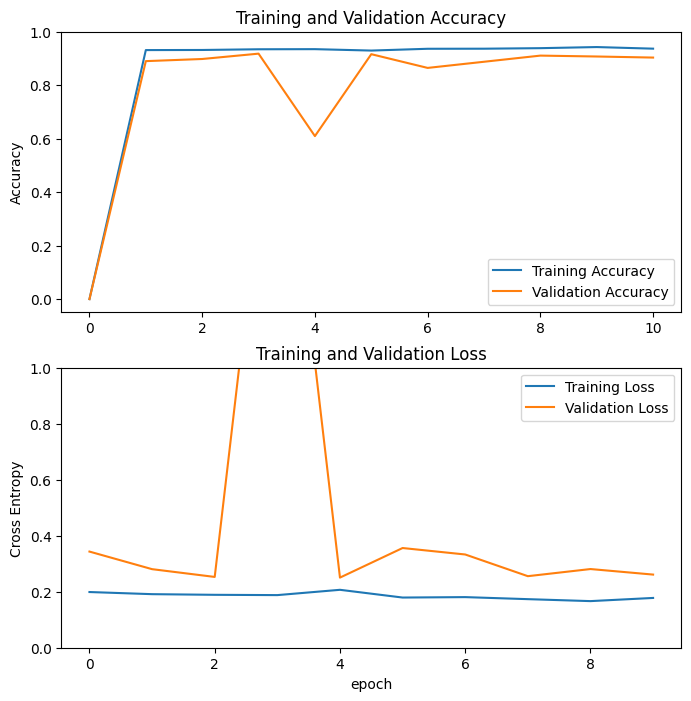

In [103]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Resuts
"Before visualizing the test results, I created a list of paths for the predicted images using the `pred_list` variable.To showcase the test results, I plotted a 3x3 grid of randomly selected images from the pred_list. For each image, I resized it to 224x224 pixels, passed it through the trained model to obtain the probability distribution, and determined the predicted label using `np.argmax()`. Finally, I displayed the image, set the title as the predicted class name from the `class_names` list, and turned off the axis ticks."

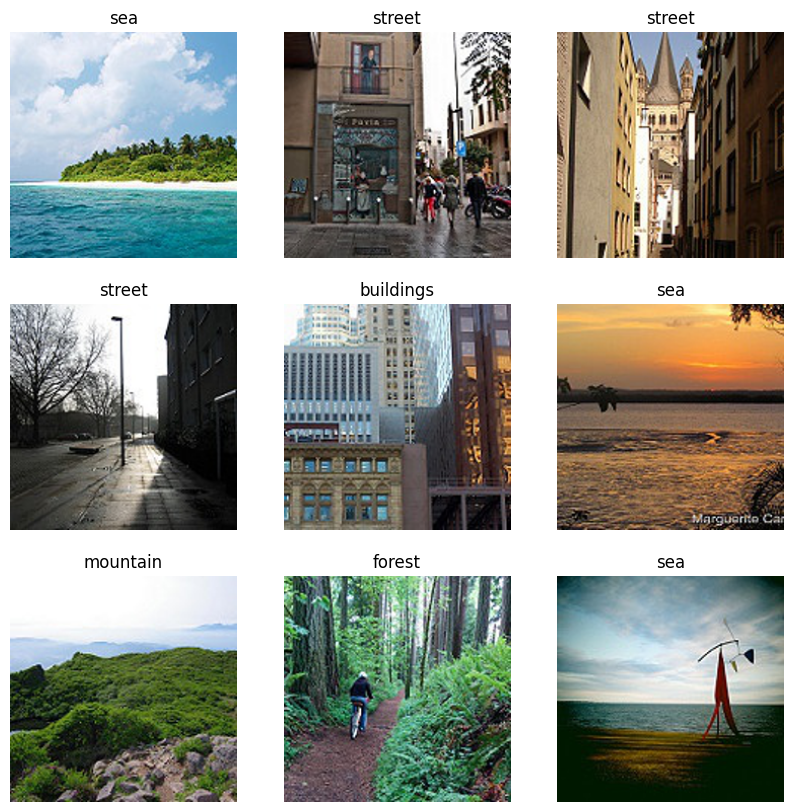

In [109]:
pred_list = [f"/content/drive/MyDrive/intel image/seg_pred/seg_pred/{i}" for i in os.listdir("/content/drive/MyDrive/intel image/seg_pred/seg_pred") ]
plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  num = random.randint(0,len(pred_list))
  img = Image.open(pred_list[num])
  img = img.resize((224 ,224))
  plt.imshow(img)
  img_array = np.array(img)
  img_array = img_array[np.newaxis , :]
  probability = model(img_array)
  pred = np.argmax(probability)
  plt.title(class_names[pred])
  plt.axis("off")

## Thank You for Reading!

Thank you for taking the time to read through my notebook. I hope you found it informative and valuable. If you are interested in contributing to this project or have any suggestions, I would be thrilled to collaborate with you.

### How to Contribute

- If you would like to contribute code or make improvements to the project, you can find the repository on GitHub [here](https://github.com/Rohitkushwaha79/intel_image). Feel free to submit pull requests or open issues.
- If you have any feedback, ideas, or questions, please don't hesitate to reach out. You can contact me at rm9093036@gmail.com
- If you found this notebook helpful, I would appreciate it if you could give it a star on GitHub and share it with others who might benefit from it.

Thank you once again for your interest in my work. I look forward to hearing from you and collaborating on this project.

Best regards,

Rohit Chandra Maurya